<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.3/Optimizer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST 데이터 셋 optimizer별 성능 비교

1) SGD <br>
2) Adagrad <br>
3) RMSprop <br>
4) Adam

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import random

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


[1] Data

In [3]:
download_root = 'MNIST_data/'

dataset1 = datasets.MNIST(root=download_root, train = True, transform = transforms.ToTensor(), download=True)

dataset2 = datasets.MNIST(root=download_root, train = False, transform = transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



[2] Model

In [12]:
# Model 정의
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(784,100)
    self.fc2 = torch.nn.Linear(100,100)
    self.fc3 = torch.nn.Linear(100,10)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    x1 = self.fc1(x)
    x2 = self.relu(x1)
    x3 = self.fc2(x2)
    x4 = self.relu(x3)
    x5 = self.fc3(x4)

    return x5


In [20]:
# batch size 정의
batch_s = 100

dataset1_loader = DataLoader(dataset1, batch_size = batch_s)
# dataset1_loader의 크기는 600 ( 60000/100)
dataset2_loader = DataLoader(dataset2, batch_size = batch_s)
# dataset2_loader의 크기는 100 ( 10000/100)

In [15]:
# 4가지의 optimizer 생성
model_dict = {}
loss_dict = {}
accuracy_dict = {}

optimizer_case = {'SGD', 'Adam', 'AdaGrad', 'RMSprop'}
for key in optimizer_case:
  model_dict[key] = Net()
  loss_dict[key] = []
  accuracy_dict[key] = []

In [16]:
# optimizer 정의
optimizer_dict = {}
optimizer_dict['SGD'] = optim.SGD(model_dict['SGD'].parameters(), lr = 0.001 )
optimizer_dict['Adam'] = optim.Adam(model_dict['Adam'].parameters(),lr= 0.001)
optimizer_dict['AdaGrad'] = optim.Adam(model_dict['AdaGrad'].parameters(),lr = 0.001)
optimizer_dict['RMSprop'] = optim.Adam(model_dict['RMSprop'].parameters(),lr = 0.001)


In [32]:
# loss function 정의
loss_function = torch.nn.CrossEntropyLoss()

# total batch size 설정
total_batch = len(dataset1_loader)

# epoch 설정
epoch = 15

[3] Training

In [37]:
from torch.nn.modules.normalization import LocalResponseNorm
for optimizer_name, optimizer in optimizer_dict.items():
  print(optimizer_name)
  for epoch_num in range(epoch):
    cost = 0
    for images, labels in dataset1_loader:
      # train할 image data
      images = images.reshape(100,784)

      # Gradient 초기화
      model_dict[optimizer_name].zero_grad()

      # feedforward
      predict = model_dict[optimizer_name].forward(images)

      # loss 구하기 - 예측한 값과 저장된 label의 차이
      loss = loss_function(predict, labels)

      # back propagation
      loss.backward()
      cost += loss

      # test data 는 gradient 를 계산할 필요가 없다
  with torch.no_grad():
      total = 0
      correct = 0 # 맞는 것의 갯수를 count
      for images, labels in dataset2_loader:
        
        images = images.reshape(100,784)
        
        outputs = model_dict[optimizer_name].forward(images)
        
        
        # softmax 를 이용해 probability 가 가장 큰 index 를 가져옴
        # ( , )에서 두번째 값은 dimension으로 1로 지정하면 하나의 행에서 max를 찾겠다는 것
        _,predict = torch.max(outputs, 1) 

        total += labels.size(0)
        correct += (predict==labels).sum()

      # update (weight 값 update)
      optimizer.step()

      avg_cost =cost / total_batch
      accuracy = 100*(correct/total)

      loss_dict[optimizer_name].append(avg_cost.detach().numpy())
      accuracy_dict[optimizer_name].append(accuracy)

      print("epoch {} 의 평균 loss 값은 ==> {:.5f}".format((epoch_num+1), avg_cost))
      print("Accuracy : {:.2f}".format(accuracy))


SGD
epoch 15 의 평균 loss 값은 ==> 2.30537
Accuracy : 8.99
Adam
epoch 15 의 평균 loss 값은 ==> 2.27946
Accuracy : 25.53
AdaGrad
epoch 15 의 평균 loss 값은 ==> 2.28165
Accuracy : 15.72
RMSprop
epoch 15 의 평균 loss 값은 ==> 2.28358
Accuracy : 10.68


Adam의 성능이 가장 좋음 확인

Adam > Adagrad > RMSprop > SGD

예측한 숫자는 8이다


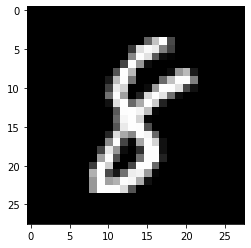

In [38]:
# 성능 평가 (original image와 predicted label 비교)
print("예측한 숫자는 {}이다".format(predict[0]))
plt.imshow(images[0].cpu().reshape(28,28), cmap = 'gray')